In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,train_test_split,cross_val_score,KFold,StratifiedKFold
from sklearn.metrics import accuracy_score,f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
import time
from warnings import simplefilter,filterwarnings
#simplefilter(action='always',category='FutureWarning')

In [2]:
train=pd.read_csv('train.csv')
#train=train[train['no_of_trainings']<10]
test=pd.read_csv('test.csv')
train.rename(columns={'KPIs_met >80%':'kpi_met_80'},inplace=True)
test.rename(columns={'KPIs_met >80%':'kpi_met_80'},inplace=True)
train.rename(columns={'awards_won?':'awards_won_prev_year'},inplace=True)
test.rename(columns={'awards_won?':'awards_won_prev_year'},inplace=True)
train.shape,test.shape

NameError: name 'pd' is not defined

In [3]:
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,kpi_met_80,awards_won_prev_year,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


## Removing NAN

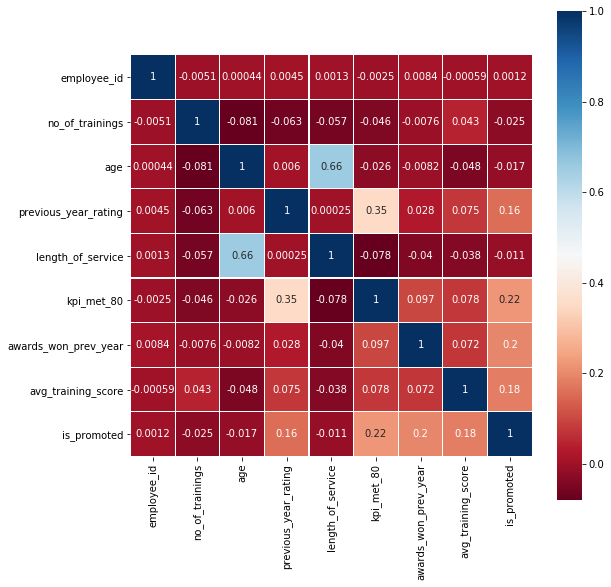

In [4]:
#filling null values based on correlation
colormap = plt.cm.RdBu
plt.figure(figsize=(9,9))
sns.heatmap(train.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
def impute(df):
    df.loc[np.logical_and(df['kpi_met_80']==0 , 
                         df['previous_year_rating'].isna()),'previous_year_rating']=3
    df.loc[np.logical_and(df['kpi_met_80']==1 , 
                         df['previous_year_rating'].isna()),'previous_year_rating']=5
    df['education'].fillna("Bachelor's",inplace=True)
    
impute(train)
impute(test)

In [5]:
train.describe().round(1)

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,kpi_met_80,awards_won_prev_year,avg_training_score,is_promoted
count,54808.0,54808.0,54808.0,54808.0,54808.0,54808.0,54808.0,54808.0,54808.0
mean,39195.8,1.3,34.8,3.4,5.9,0.4,0.0,63.4,0.1
std,22586.6,0.6,7.7,1.2,4.3,0.5,0.2,13.4,0.3
min,1.0,1.0,20.0,1.0,1.0,0.0,0.0,39.0,0.0
25%,19669.8,1.0,29.0,3.0,3.0,0.0,0.0,51.0,0.0
50%,39225.5,1.0,33.0,3.0,5.0,0.0,0.0,60.0,0.0
75%,58730.5,1.0,39.0,4.0,7.0,1.0,0.0,76.0,0.0
max,78298.0,10.0,60.0,5.0,37.0,1.0,1.0,99.0,1.0


train:


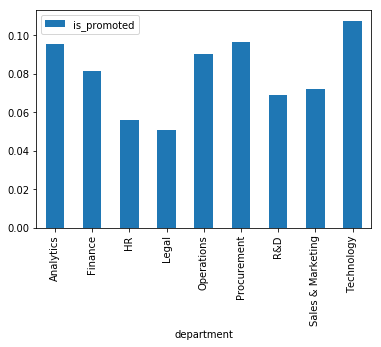

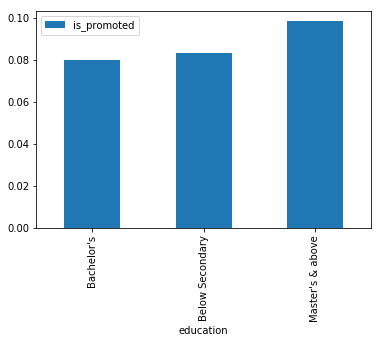

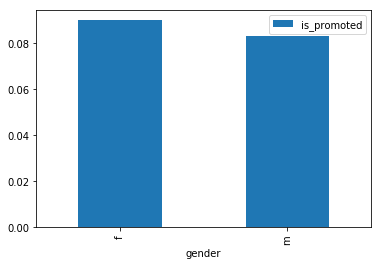

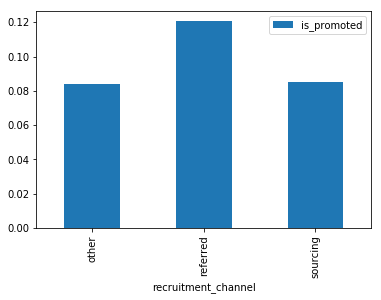

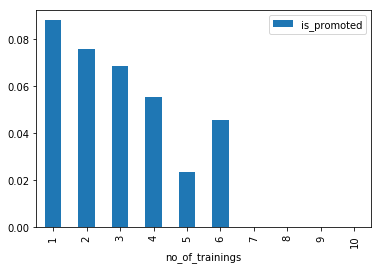

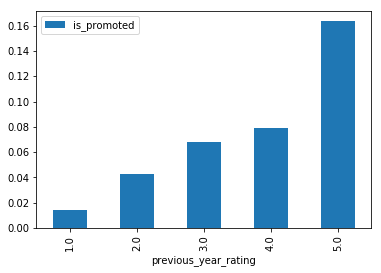

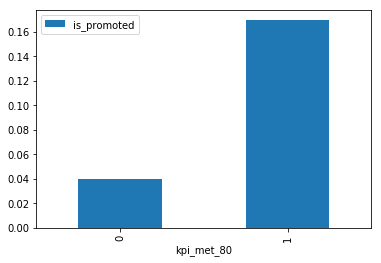

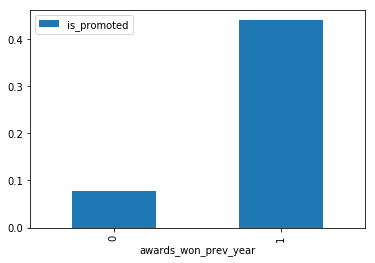

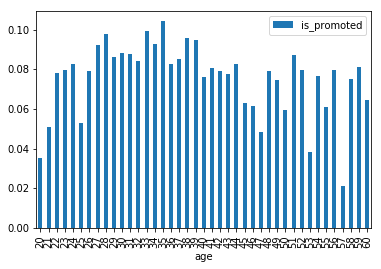

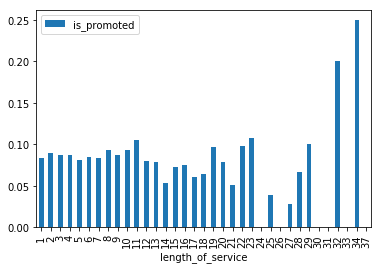

In [6]:
def plot_pivots(df):
    for i in ['department','education','gender','recruitment_channel','no_of_trainings',
              'previous_year_rating','kpi_met_80','awards_won_prev_year','age','length_of_service']:
        df.pivot_table(index=i,values='is_promoted').plot.bar()#.sort_values('is_promoted').plot.bar()
        plt.show()
print('train:')
plot_pivots(train)


## Removing Correlation

In [7]:
def corr(df):
    df['expertise']=df['length_of_service']/df['age']*df['length_of_service']
    df.drop(['length_of_service'],axis=1,inplace=True)
corr(train)
corr(test)

## Adding features

In [8]:
def add_features(df):
    df.loc[np.logical_and(df['kpi_met_80']==1,df['awards_won_prev_year']==1),'def_great']=1
    df['def_great'].fillna(0,inplace=True)
    for i in range(2,6):
        df.loc[np.logical_and(df.awards_won_prev_year==1,df.previous_year_rating==i),
           'rated_awards_'+str(i)]=1
        df['rated_awards_'+str(i)].fillna(0,inplace=True)
    
    for i in range(1,5):
        df.loc[np.logical_and(df['kpi_met_80']==1,df['previous_year_rating']==i)
              ,'kp_rating_level'+str(i)]=1
        df['kp_rating_level'+str(i)].fillna(0,inplace=True)
    #df.drop('previous_year_rating',axis=1,inplace=True)
    
add_features(train)
add_features(test)

####Binning
def age_cut(df,bins,labels):
    df['age_cat']=pd.cut(df['age'],bins=bins,labels=labels)
    return df
bins=[19,30,40,50,70]
labels=['young','adults','expert_adults','old']
train=age_cut(train,bins,labels)
test=age_cut(test,bins,labels)

## Target Encoding With Smoothening

In [9]:
def target_encoding(df):
    for i in ['department','education','gender','region' ,'recruitment_channel',
                'no_of_trainings','region','age_cat','previous_year_rating']:
        agg_df=train.groupby(i)['is_promoted'].agg(['count', 'mean'])
        mean=train.is_promoted.mean()
        smooth=(agg_df['count']*agg_df['mean'] + 10 * mean)/(agg_df['count'] + 10)
        df[str(i) + '_scaled'] = df[i].map(smooth)
target_encoding(train)
target_encoding(test)

In [10]:
from sklearn.preprocessing import minmax_scale
train['avg_training_score']=minmax_scale(train.avg_training_score)
train['expertise']=minmax_scale(train.expertise)
test['avg_training_score']=minmax_scale(test.avg_training_score)
test['expertise']=minmax_scale(test.expertise)

In [11]:
train.iloc[:,9:].drop('awards_won_prev_year',axis=1)

,kpi_met_80,avg_training_score,is_promoted,expertise,def_great,rated_awards_2,rated_awards_3,rated_awards_4,rated_awards_5,kp_rating_level1,...,kp_rating_level4,age_cat,department_scaled,education_scaled,gender_scaled,region_scaled,recruitment_channel_scaled,no_of_trainings_scaled,age_cat_scaled,previous_year_rating_scaled
0,1,0.166667,0,0.079203,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,adults,0.072039,0.098550,0.089931,0.106501,0.085013,0.088106,0.090631,0.163712
1,0,0.350000,0,0.022378,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,young,0.090144,0.080098,0.083152,0.114143,0.083952,0.088106,0.085550,0.163712
2,0,0.183333,0,0.062207,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,adults,0.072039,0.080098,0.083152,0.060918,0.085013,0.088106,0.090631,0.068365
3,0,0.183333,0,0.111473,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,adults,0.072039,0.080098,0.083152,0.116331,0.083952,0.075760,0.090631,0.014255
4,0,0.566667,0,0.002879,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,expert_adults,0.107562,0.080098,0.083152,0.063371,0.083952,0.088106,0.072743,0.068365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54803,0,0.650000,0,0.263128,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,expert_adults,0.107562,0.080098,0.083152,0.075092,0.085013,0.088106,0.072743,0.068365
54804,0,0.283333,0,0.041666,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,adults,0.090144,0.098550,0.089931,0.079000,0.083952,0.088106,0.090631,0.042940
54805,1,0.666667,0,0.013604,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,young,0.095646,0.080098,0.083152,0.094922,0.083952,0.088106,0.085550,0.163712
54806,0,0.100000,0,0.005031,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,young,0.072039,0.080098,0.083152,0.020585,0.085013,0.088106,0.085550,0.014255


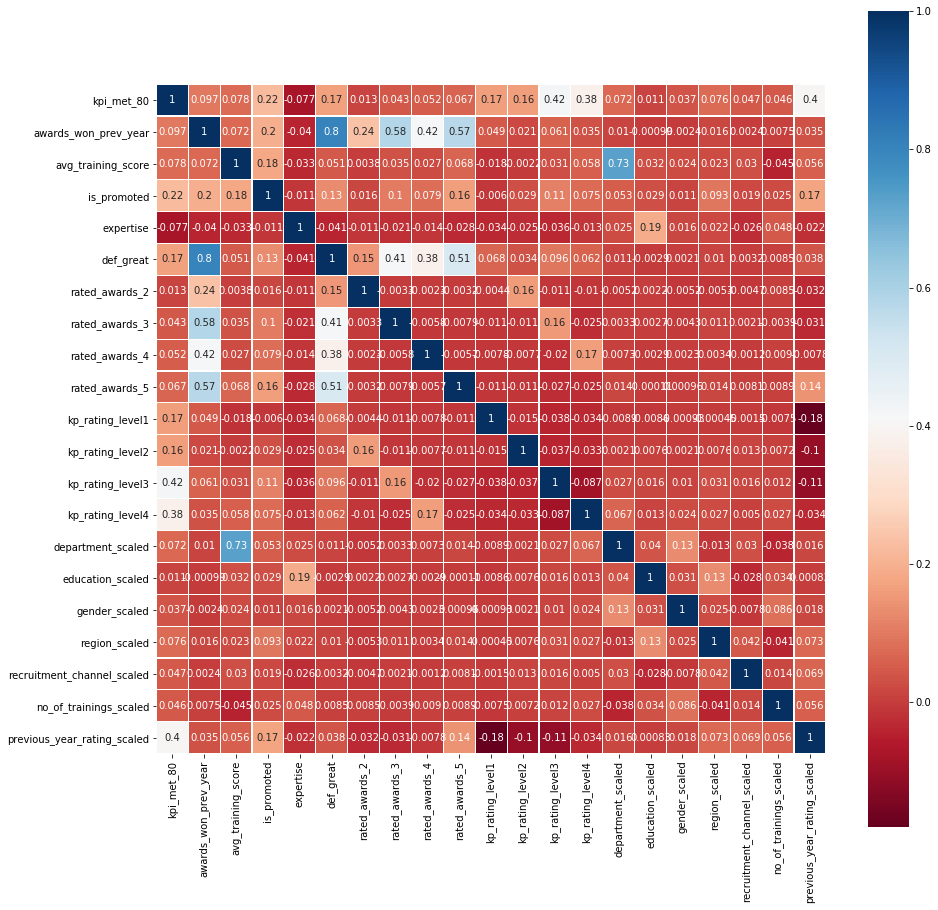

In [13]:
colormap = plt.cm.RdBu
plt.figure(figsize=(15,15))
sns.heatmap(train.iloc[:,9:].corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

## Modelling

## Random Classifier

In [70]:
import numpy as np
np.arange(5)
range(5)

range(0, 5)

In [12]:
columns=train.columns[9:]
columns=columns.drop(['is_promoted','age_cat','awards_won_prev_year'])
predictions=[]
predictions_train=[]

In [13]:
filterwarnings('ignore')
from imblearn.over_sampling import SMOTE
train_scores,val_scores=[],[]
skf=StratifiedKFold(n_splits=11,shuffle=True,random_state=22)
for train_idx,val_idx in skf.split(train[columns],train.is_promoted):
    train_X,val_X = train.iloc[train_idx,:] , train.iloc[val_idx,:]
    train_y,val_y = train.is_promoted[train_idx],train.is_promoted[val_idx]
    
    tic=time.time()
    sm=SMOTE(random_state=22)
    train_X_rs,train_y_rs=sm.fit_sample(train_X[columns],train_y)
    model=RandomForestClassifier(n_estimators=100, 
                                 min_samples_split=5, 
                                 min_samples_leaf=1, 
                                 max_features=0.7,
                                 max_depth=100, 
                                 bootstrap=True)
    model.fit(train_X_rs,train_y_rs)
    predictions.append(model.predict(test[columns]))
    predictions_train.append(model.predict(train[columns]))
    train_scores.append(f1_score(model.predict(train_X_rs),train_y_rs))
    print('train : {}'.format(f1_score(model.predict(train_X_rs),train_y_rs)))
    val_scores.append(f1_score(model.predict(val_X[columns]),val_y))
    print('val : {}'.format(f1_score(model.predict(val_X[columns]),val_y)))
print('train score: {}'.format(np.array(train_scores).mean().round(3))
      ,'val score: {}'.format(np.array(val_scores).mean().round(3)))

train : 0.9927447407652806
val : 0.45723172628304826
train : 0.9928224381625441
val : 0.44372990353697744
train : 0.9930100818251085
val : 0.42654028436018954
train : 0.9931109099339797
val : 0.4917043740573152
train : 0.9927671462803256
val : 0.5052631578947369
train : 0.99283371796429
val : 0.4839203675344563
train : 0.9926444601519703
val : 0.49275362318840576
train : 0.9925107699105268
val : 0.4944178628389155
train : 0.9929215852998664
val : 0.4526484751203852
train : 0.9928891637038183
val : 0.5121951219512195
train : 0.9931442576257714
val : 0.4694835680751173
train score: 0.993 val score: 0.475


## Catboost

In [14]:
from imblearn.over_sampling import SMOTE
train_scores,val_scores=[],[]
skf=StratifiedKFold(n_splits=11,shuffle=True,random_state=402)
for train_idx,val_idx in skf.split(train[columns],train.is_promoted):
    train_X,val_X = train.iloc[train_idx,:] , train.iloc[val_idx,:]
    train_y,val_y = train.is_promoted[train_idx],train.is_promoted[val_idx]
    
    tic=time.time()
    sm=SMOTE(random_state=402)
    train_X_rs,train_y_rs=sm.fit_sample(train_X[columns],train_y)
    from catboost import CatBoostClassifier
    cb = CatBoostClassifier(
        iterations=700,
        learning_rate=0.08,
        #random_strength=0.1,
        depth=8,
        loss_function='Logloss',
        eval_metric='F1',
        metric_period = 100,    
        leaf_estimation_method='Newton')
    cb.fit(train_X_rs, train_y_rs,
                 eval_set=(val_X[columns],val_y),
                 #cat_features=categorical_var,
                 use_best_model=True,
                 verbose=False)
    predictions.append(cb.predict(test[columns]))
    predictions_train.append(cb.predict(train[columns]))
    train_scores.append(f1_score(cb.predict(train_X_rs),train_y_rs))
    print('train : {}'.format(f1_score(cb.predict(train_X_rs),train_y_rs)))
    val_scores.append(f1_score(cb.predict(val_X[columns]),val_y))
    print('val : {}'.format(f1_score(cb.predict(val_X[columns]),val_y)))
print('train score: {}'.format(np.array(train_scores).mean().round(3))
      ,'val score: {}'.format(np.array(val_scores).mean().round(3)))

train : 0.9752727843629799
val : 0.5129032258064515
train : 0.9530731372324598
val : 0.4829931972789116
train : 0.9689220908188138
val : 0.47457627118644063
train : 0.9692704985509207
val : 0.4868421052631579
train : 0.9716368709426999
val : 0.48172757475083056
train : 0.9665555241593671
val : 0.543657331136738
train : 0.9614493938155565
val : 0.47986577181208045
train : 0.9731478776711682
val : 0.532695374800638
train : 0.9694946601558535
val : 0.5252854812398042
train : 0.9625503431845255
val : 0.5182724252491695
train : 0.969500309841699
val : 0.5008403361344538
train score: 0.967 val score: 0.504


## XGBoost

In [15]:
skf=StratifiedKFold(n_splits=11,shuffle=True,random_state=355)
from xgboost import XGBClassifier
train['age_cat_scaled']=train['age_cat_scaled'].astype('float64')
test['age_cat_scaled']=test['age_cat_scaled'].astype('float64')
columns=train.columns[9:]
columns=columns.drop(['is_promoted','awards_won_prev_year','age_cat'])
train_scores,val_scores=[],[]
for train_idx,val_idx in skf.split(train[columns],train.is_promoted):
    train_X,val_X = train.iloc[train_idx,:] , train.iloc[val_idx,:]
    train_y,val_y = train.is_promoted[train_idx],train.is_promoted[val_idx]
    
    ''''tic=time.time()
    sm=SMOTE(random_state=42)
    train_X_rs,train_y_rs=sm.fit_sample(train_X[columns],train_y)'''
    xg=XGBClassifier(
                learning_rate =0.06,
                 n_estimators=1000,
                 max_depth=5,
                 min_child_weight=3,
                 gamma=0,
                 subsample=0.8,
                 colsample_bytree=0.8,
                 objective= 'binary:logistic',
                 nthread=4,
                 scale_pos_weight=1,
                 seed=27,verbose=True)
    xg.fit(train_X[columns],train_y)
    predictions.append(xg.predict(test[columns]))
    predictions_train.append(xg.predict(train[columns]))
    train_scores.append(f1_score(xg.predict(train_X[columns]),train_y))
    print('train : {}'.format(f1_score(xg.predict(train_X[columns]),train_y)))
    val_scores.append(f1_score(xg.predict(val_X[columns]),val_y))
    print('val : {}'.format(f1_score(xg.predict(val_X[columns]),val_y)))
print('train score: {}'.format(np.array(train_scores).mean().round(3))
      ,'val score: {}'.format(np.array(val_scores).mean().round(3)))



train : 0.5864735889419121
val : 0.4914089347079038
train : 0.5850677238189627
val : 0.501628664495114
train : 0.5779177718832892
val : 0.5756578947368421
train : 0.5850519716218446
val : 0.5373134328358209
train : 0.5817641228939544
val : 0.5361842105263158
train : 0.5830441249380268
val : 0.46045694200351506
train : 0.5814262023217247
val : 0.4957264957264957
train : 0.588641975308642
val : 0.5016949152542373
train : 0.5850519716218445
val : 0.5100671140939598
train : 0.5870925255186039
val : 0.4863013698630137
train : 0.5893592488881568
val : 0.4822934232715008
train score: 0.585 val score: 0.507


## Ensembling

## Voting

train:


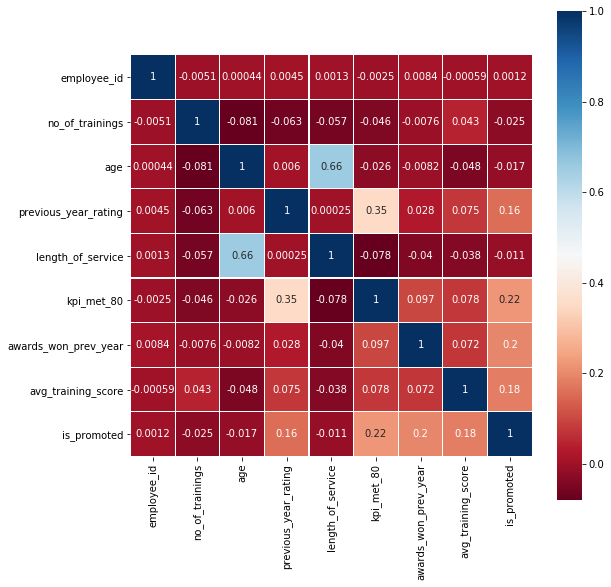

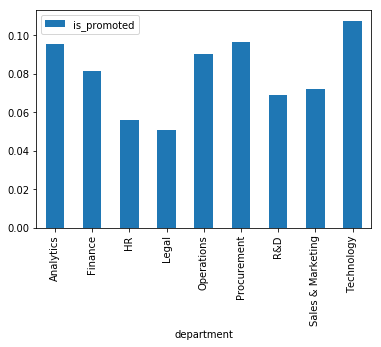

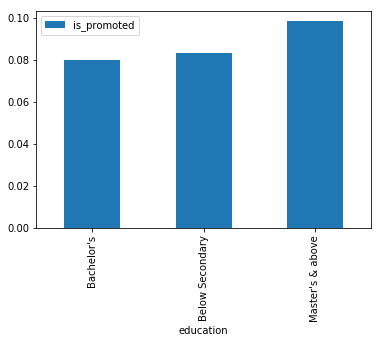

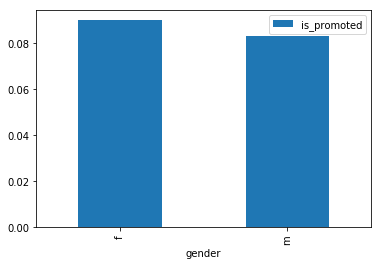

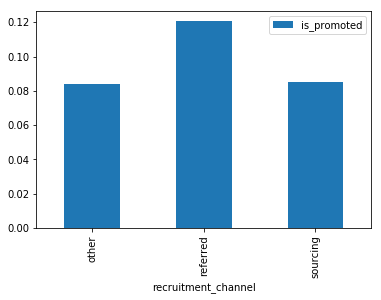

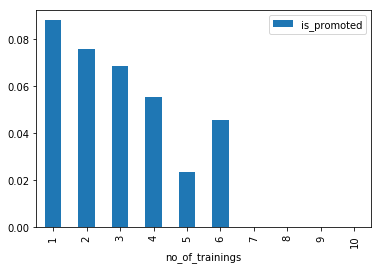

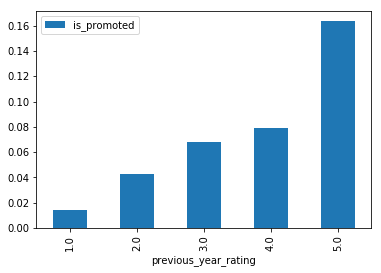

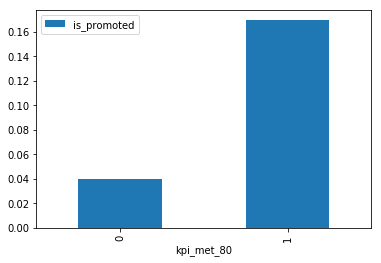

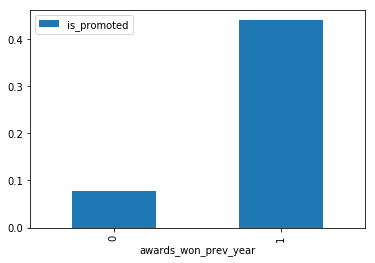

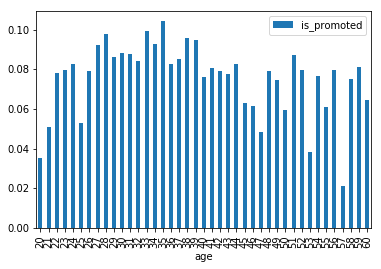

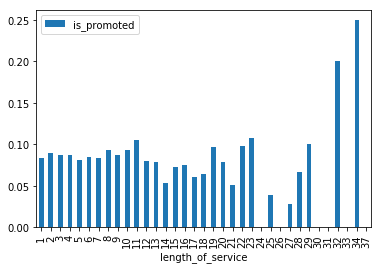

train : 0.994769471331197
val : 0.5
train : 0.9947823789710059
val : 0.47417218543046363
train : 0.9944717309428893
val : 0.49732620320855625
train : 0.9948478576775728
val : 0.46849315068493147
train : 0.9944279264398194
val : 0.5013774104683195
train : 0.9947935585421964
val : 0.5031446540880503
train : 0.9948579041830454
val : 0.4867724867724868
train : 0.9947151696650739
val : 0.4899598393574297
train : 0.9945832874600903
val : 0.49934296977660975
train : 0.994969564212357
val : 0.485753052917232
train : 0.994726818366965
val : 0.49046321525885567
train score: 0.995 val score: 0.491
0:	learn: 0.8194254	test: 0.3173949	best: 0.3173949 (0)	total: 151ms	remaining: 1m 45s
100:	learn: 0.9278744	test: 0.4446323	best: 0.4446323 (100)	total: 13.9s	remaining: 1m 22s
200:	learn: 0.9553265	test: 0.4782609	best: 0.4782609 (200)	total: 27.5s	remaining: 1m 8s
300:	learn: 0.9615182	test: 0.4964739	best: 0.4964739 (300)	total: 41s	remaining: 54.3s
400:	learn: 0.9644680	test: 0.5036179	best: 0.5036

100:	learn: 0.9287766	test: 0.4747826	best: 0.4747826 (100)	total: 16.5s	remaining: 1m 37s
200:	learn: 0.9545854	test: 0.5147059	best: 0.5147059 (200)	total: 32.4s	remaining: 1m 20s
300:	learn: 0.9612854	test: 0.5163043	best: 0.5163043 (300)	total: 48.4s	remaining: 1m 4s
400:	learn: 0.9643637	test: 0.5216179	best: 0.5216179 (400)	total: 1m 4s	remaining: 48.2s
500:	learn: 0.9669934	test: 0.5304965	best: 0.5304965 (500)	total: 1m 20s	remaining: 32s
600:	learn: 0.9689267	test: 0.5361702	best: 0.5361702 (600)	total: 1m 36s	remaining: 15.9s
699:	learn: 0.9703897	test: 0.5352113	best: 0.5361702 (600)	total: 1m 53s	remaining: 0us

bestTest = 0.5361702128
bestIteration = 600

Shrink model to first 601 iterations.
train : 0.9689267431202916
val : 0.5361702127659574
0:	learn: 0.8046041	test: 0.3353184	best: 0.3353184 (0)	total: 190ms	remaining: 2m 12s
100:	learn: 0.9276314	test: 0.4805915	best: 0.4805915 (100)	total: 16.3s	remaining: 1m 36s
200:	learn: 0.9548959	test: 0.4960630	best: 0.4960630 (

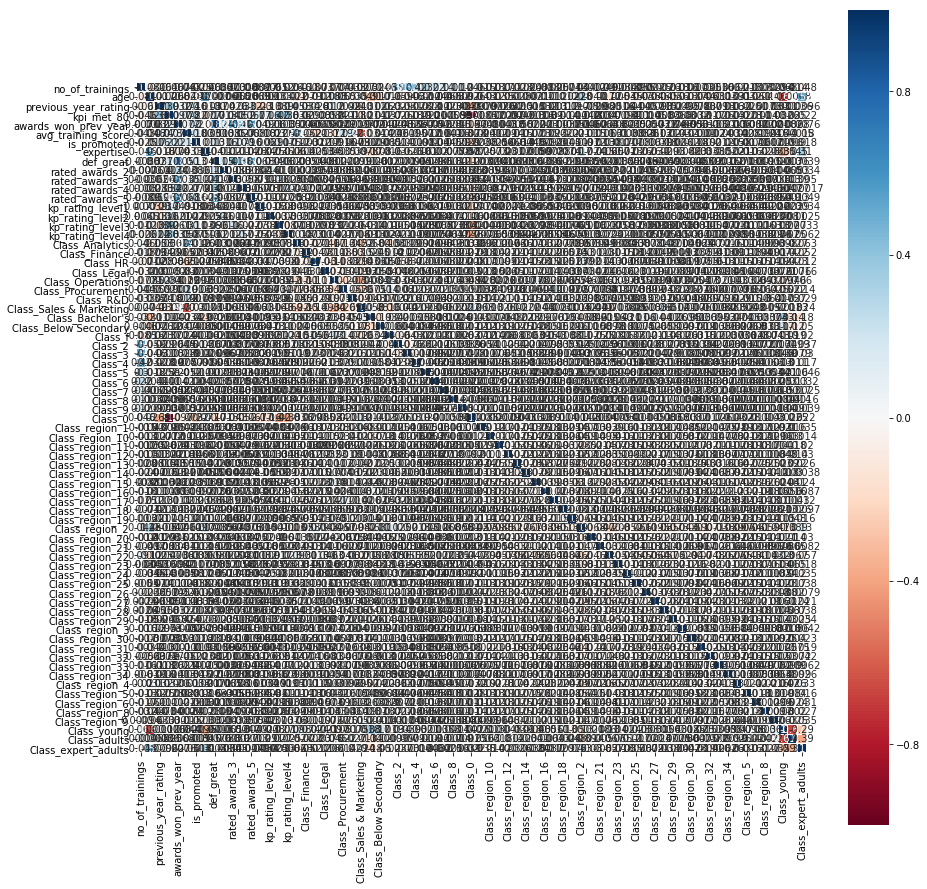

In [93]:
from HR import predictions1

In [98]:
new_predictions=predictions1+predictions

In [142]:
# Averaging
#weights=[0.1]*11 + [0.45]*11 + [0.45]*11
avg_prediction = []
for j in range(len(predictions[0])):
    avg_prediction.append(np.mean([prediction[j] for prediction in new_predictions])) 
#avg_prediction.append(np.mean(np.multiply([prediction[j] for prediction in predictions],weights)))

In [143]:
for i in range(len(avg_prediction)):
    if avg_prediction[i]>=0.18:
        avg_prediction[i]=1
    else:
        avg_prediction[i]=0

In [159]:
#Major Voting
votes=new_predictions[0]
for i in range(1,77):
    votes=votes+new_predictions[i]

In [160]:
#votes=predictions[0]+predictions[1]+predictions[2]
for i in range(len(votes)):
    if votes[i]>=(len(new_predictions)/2):
        votes[i]=1
    else:
        votes[i]=0

## Stacking

In [63]:
train_stack=pd.DataFrame(data=predictions_train).transpose()
test_stack=pd.DataFrame(data=predictions).transpose()

In [64]:
train_stack.shape

(54808, 33)

In [67]:
skf=StratifiedKFold(n_splits=11,shuffle=True,random_state=355)
train_scores,val_scores=[],[]
for train_idx,val_idx in skf.split(train_stack,train.is_promoted):
    train_X,val_X = train_stack.iloc[train_idx,:] , train_stack.iloc[val_idx,:]
    train_y,val_y = train.is_promoted[train_idx],train.is_promoted[val_idx]
    model.fit(train_X,train_y)
    train_scores.append(f1_score(model.predict(train_X),train_y))
    print('train : {}'.format(f1_score(model.predict(train_X),train_y)))
    val_scores.append(f1_score(model.predict(val_X),val_y))
    print('val : {}'.format(f1_score(model.predict(val_X),val_y)))
print('train score: {}'.format(np.array(train_scores).mean().round(3))
      ,'val score: {}'.format(np.array(val_scores).mean().round(3)))

train : 0.9660359049005337
val : 0.9748502994011976
train : 0.9669211195928754
val : 0.963855421686747
train : 0.9670462805912284
val : 0.9635922330097086
train : 0.9674057918332728
val : 0.9574726609963548
train : 0.966537342386033
val : 0.9664268585131894
train : 0.9671554963034783
val : 0.9612590799031477
train : 0.9654587322748757
val : 0.9712230215827338
train : 0.966662625772821
val : 0.966183574879227
train : 0.9670781893004116
val : 0.9549330085261876
train : 0.9682885499878965
val : 0.9485294117647058
train : 0.9670382937469704
val : 0.9565217391304348
train score: 0.967 val score: 0.962


## Learning Curves

In [1]:
from sklearn.model_selection import learning_curve
'''for i in [14,19,28,31,33,35,43,45]:
    columns=train.columns[8:i]
    columns=columns.drop('is_promoted')
    filterwarnings('ignore')*/'''
def plot_learning_curves(train_sizes,estimator,X,y,cv):
    train_size,train_scores,val_scores=learning_curve(estimator=estimator,X=X,y=y,
                                                train_sizes=train_sizes,cv=cv,scoring='f1',
                                                     shuffle=True)
    train_scores_mean= 1-train_scores.mean(axis=1)
    val_scores_mean= 1-val_scores.mean(axis=1)
    #print(str(i)+'............................../n')
    plt.figure(figsize=(10,5))
    plt.plot(train_sizes,train_scores_mean,label='Train error')
    plt.plot(train_sizes,val_scores_mean,label='Val error')
    plt.ylabel('f1 error', fontsize = 14,color='yellow')
    plt.xlabel('Training set size', fontsize = 14,color='yellow')
    plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03,color='yellow')
    plt.legend()
    plt.ylim(0,1)

clf=RandomForestClassifier(n_estimators=10,min_samples_split=5,
                      min_samples_leaf= 1, max_features= 0.5,
                       max_depth = 46,bootstrap = True)   
train_sizes=np.linspace(0.1,1,10)
plot_learning_curves(estimator=model,X=train_X_rs,y=train_y_rs,
                    train_sizes=train_sizes,cv=10)


NameError: name 'np' is not defined

In [54]:
clf.fit(train_X,train_y)
test_X['actual']=train.loc[test_X.index,'is_promoted']
test_X['predicted']=clf.predict(test_X[columns])

In [106]:
false_positive=test_X[np.logical_and(test_X.predicted==1,test_X.actual==0)]
false_negative=test_X[np.logical_and(test_X.predicted==0,test_X.actual==1)]
false_positive.kpi_met_80.value_counts()

1    95
0    21
Name: kpi_met_80, dtype: int64

## Submission

In [161]:
holdout_predictions=np.int64(votes)
#holdout_predictions=[0]*test.shape[0]

In [156]:
test['holdout']=holdout_predictions
test.holdout.value_counts()

0    22390
1     1100
Name: holdout, dtype: int64

In [157]:
submission_dict={'employee_id':test['employee_id'],
              'is_promoted':holdout_predictions}
submission_df=pd.DataFrame(data=submission_dict)
submission_df.to_csv('Submission.csv',index=False)

In [37]:
train[train.is_promoted==1].shape,train.shape

((4668, 73), (54803, 73))

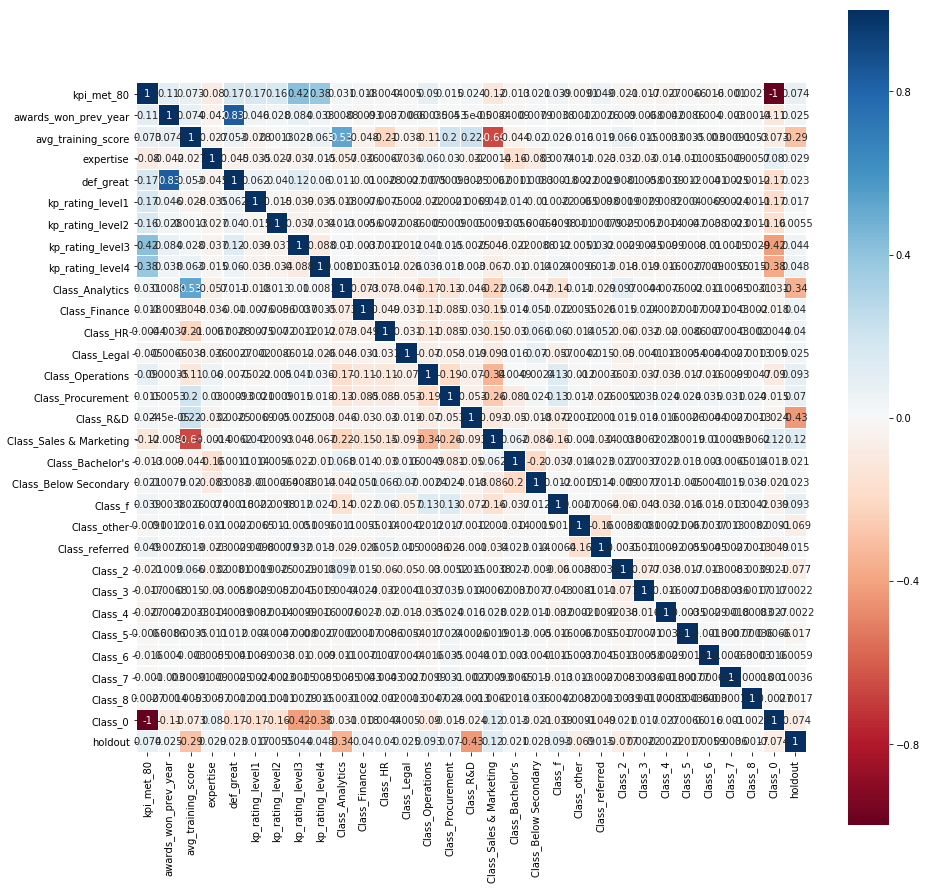

In [324]:
colormap = plt.cm.RdBu
plt.figure(figsize=(15,15))
sns.heatmap(check.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [319]:
check=test[list(optimal_columns) + ['holdout']]
check[check.holdout==0]

,kpi_met_80,awards_won_prev_year,avg_training_score,expertise,def_great,kp_rating_level1,kp_rating_level2,kp_rating_level3,kp_rating_level4,Class_Analytics,...,Class_referred,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_0,holdout
47,1,0,84,0.000439,0.0,0.0,0.0,0.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
90,0,0,86,0.046881,0.0,0.0,0.0,0.0,0.0,0,...,0,1,0,0,0,0,0,0,1,0
102,1,0,86,0.000687,0.0,0.0,0.0,0.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
127,0,0,80,0.000687,0.0,0.0,0.0,0.0,0.0,1,...,0,0,0,0,0,0,0,0,1,0
155,0,0,82,0.147618,0.0,0.0,0.0,0.0,0.0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23356,0,0,82,0.029558,0.0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,1,0
23375,0,0,87,0.000555,0.0,0.0,0.0,0.0,0.0,1,...,0,0,0,0,0,0,0,0,1,0
23377,0,0,88,0.000687,0.0,0.0,0.0,0.0,0.0,1,...,0,0,0,0,0,0,0,0,1,0
23426,0,0,87,0.025585,0.0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,1,0


In [57]:
N=int(input())
arr_1 = list(map(int,input().split()))
arr_2 = list(map(int,input().split()))
for i in range(len(arr_1)):
    print(arr_1[i] + arr_2[i] , end=' ')

5
1 2 3 4 5
5 4 3 2 1
6 6 6 6 6 

In [58]:
arr_1

[1, 2, 3, 4, 5]

In [42]:
#palindrome
T = int(input())
cases=list()
for i in range(T):
    cases.append(str(input()))
for j in cases:
    check=0
    for i in range(int(len(j)/2)):
        if j[i]==j[len(j)-1-i]:
            check+=0
        else :
            check+=1
    if check==0 and len(j)%2==0:
        print('YES EVEN')
    elif check==0 and len(j)%2!=0:
        print('YES ODD')
    else:    
        print('NO')

5
abc
a
ab
abcba
abcddcba


In [1]:
#Matrix Inversion
T = int(input())
cases=list()
for i in range(T):
    cases1=list()
    N = int(input( ))
    for i in range(N):
        i = list(map(int,input().split()))
        cases1.append(i)
    cases.append(cases1)
for m in cases:
    check=0
    for row in range(len(m)):
        for column in range(len(m)):
                k=0
                while((row+k)<=(len(m)-1)):
                    for i in range(len(m)-column):
                        if m[row][column]>m[row+k][len(m)-1-i]:
                            check+=1
                    k=k+1
    print(check)



2
3
1 2 3
4 5 6
7 8 9
2
4 3
1 4


In [15]:
#Substring
string = (input())
vowel = 'aeiou'
c1,c2=0,0
for i in string:
    if vowel.find(i)!=-1:
        c1+=1
    else:
        if c1>c2:
            c2=c1
        c1=0
if c1>c2:
    c2=c1
print(c2)

a
1


In [2]:
T=int(input().strip())
array=[]
rotation=[]
for i in range(T):
    N,K = input().split(' ')
    rotation.append((int(K)))
    array.append(( list(map(int,input().split())) ))
for j in range(len(rotation)):
    if rotation[j]==0:
        for i in array[j]:
            print(i,end=' ')
    if rotation[j]!=0 and rotation[j]<=len(array[j]):
        x=(array[j][len(array[j])-rotation[j]:])
        array[j]=array[j][:len(array[j])-rotation[j]]
        array[j]=x+array[j]
        for i in array[j]:
            print(i,end=' ')
    if rotation[j]!=0 and rotation[j]>len(array[j]):
        rotation[j]=rotation[j]%len(array[j])
        x=(array[j][len(array[j])-rotation[j]:])
        array[j]=array[j][:len(array[j])-rotation[j]]
        ahttp://localhost:8888/notebooks/Desktop/DS/AV/HR/HR-Copy1.ipynb#rray[j]=x+array[j]
        for i in array[j]:
            print(i,end=' ')
    print()http://localhost:8888/notebooks/Desktop/DS/AV/HR/HR-Copy1.ipynb#

2
5 2
1 2 3 4 5
1 0
1
4 5 1 2 3 
1 


In [5]:
N,K = map(int,input().split(' '))
from fractions import gcd
def num_comm_div(x, y):
    
      n = gcd(x, y)
      result = 0
      z = int(n**0.5)
      i = 1
      while( i <= z ):
        if(n % i == 0):
          result += 2 
          if(i == n/i):
            result-=1
        i+=1
      print(result)
        return result
num_comm_div(N,K)

1000000000 1000000000


C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: fractions.gcd() is deprecated. Use math.gcd() instead.
  after removing the cwd from sys.path.


100

In [22]:
N,K = map(int,input().split(' '))
arr = list(map(int,input().split())) 

import numpy as np
sort = (np.array(arr)%K)

f={}
for i in np.unique(sort):
    f[i]=[]
for i,j in zip(arr,sort):
    f[j].append(i) 
for i in  np.unique(sort):
    for j in f[i]:
        print(j,end=' ')

10 100000000
1 6 5 4 8 9 5 2 3 7 10
1 2 3 4 5 5 6 7 8 9 10 

In [20]:
import numpy as np
string,K = (input().split(' '))
s=list(string)
q=[]
for i in range(len(string)):
    q.append(string[i:])
z=np.unique(q)
print(z[int(K)-1])

abaac 1
aac


In [81]:
import numpy as np
N = int(input().strip())
arr = []
for i in range(N):
    arr.append(input())

for i in range(len(arr)):
    y=arr[:(i+1)]
    c=0
    for j in range(len(y)):
        if y[j]<y[len(y)-1]:
            c+=1
        
    print(c)

5
a
a
a
a
a
0
0
0
0
0


In [38]:
N = int(input().strip())
strs = []
for i in range(N):
    strs.append(input())
vowels = ['a','e','i','o','u']
for j in strs:
    cons_count = 0
    vow_count = 0
    for i in j:
            if i in vowels:
                vow_count+=1
                cons_count = 0
            if ~(i in vowels):
                cons_count += 1
            if cons_count == 3:
                print('hard')
                break
    if vow_count >= len(j)/2 :
        print('easy')

5
qiewldoaa
life
ayayayyy
szczebrzeszyn
gg
hard
easy
hard
hard


In [2]:
N = int(input().strip())
arr = []
for i in range(N):
    arr.append(int(input()))
for i in arr:
    if i%2 !=0 :
        print(( 26 ** (int(i/2)+1))%(10**9 + 9))
    else:
        print(( 26 ** (int(i/2)))%(10**9 + 9))


1
1000000001
0


In [ ]:
  /\
 /  \
/ /\ \
 

In [1]:
N = int(input().strip())


3


In [29]:
for i in range(N):
    print(' '*(N-i-1) +'/' +' '*(2*i) + '\ ')
    
for i in reversed(range(N)):
    print(' '*(N-i+2-1) +'\ ' +' '*(2*i+0) + '/')

  /\ 
 /  \ 
/    \ 
  \     /
   \   /
    \ /


In [30]:
T = int(input().strip())
N_arr = []
seq_arr = []
for i in range(T):
    N_arr.append(int(input().strip()))
    seq_arr.append((( list(map(int,input().split())) )))

2
4
1 2 6 5
5
2 6 5 4 7


In [33]:
N_arr
for i  in seq_arr:
    print(sorted(i))

[1, 2, 5, 6]
[2, 4, 5, 6, 7]
